Gender: Gênero (M/Masculino or F/Feminino).

EDUC (Education): Anos de educação.

SES (Socialeconomic Status): Status socioeconômico avaliado pelo Hollingshead Index of Social Position. Classificado em categorias de 1 (Maior status) até 5 (Menor status) (Hollingshead, 1957)

MMSE (Mini-Mental State Exam): Pontuação do Exame de Estado Mini-Mental. Varia entre 0 [pior] e 30 [melhor] (Folstein, Folstein, & McHugh, 1975)

CDR (Clinical Dementia Rating): Avaliação clínica do grau de TCM (Transtorno Maior Cognitivo / Demência) (0 = sem TCM, 0.5 = Alzheimer bem leve, 1 = Alzheimer leve, 2 = Alzheimer Moderado) (Morris, 1993) — Há o grau 3 = severo, porém não foi documentado em nenhum paciente.

eTIV (Estimated Total Intracranial Volume): Estimativa do volume intracraniano total (cm3) (Buckner et al., 2004)

nWBV (Normalized Whole Brain Volume): Expressa a porcentagem de todos os voxels na imagem da forma atlas, que estão marcados como matéria branca ou cinza pelo processo automatizado de segmentação do tecido, isto com base no eTIV (Fotenos et al., 2005)

ASF (Atlas Scaling Factor): Fator Atlas de escala (sem unidade). Fator de escala computado que transforma o espaço nativo do cérebro e do crânio em um objeto atlas (i.e. o determinante da matrix de transformação) (Buckner et al., 2004)



Algumas análises estão faltantes por motivo de desorganização...

In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import scipy.stats as stats

import torch    

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importando os dados
"""
    Longitudinal MRI Data in Nondemented and Demented Older Adults:
        This set consists of a longitudinal collection of 150 subjects aged 60 to 96.
        Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions.
        For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included.
        The subjects are all right-handed and include both men and women.
        72 of the subjects were characterized as nondemented throughout the study.
        64 of the included subjects were characterized as demented at the time of their initial visits
        and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease.
        Another 14 subjects were characterized as nondemented at the time of their initial visit and were
        subsequently characterized as demented at a later visit.
"""

# oasis_cross_sectional = pd.read_csv('oasis_cross-sectional.csv')
oasis_longitudinal = pd.read_csv('data/oasis_longitudinal.csv')

# For every row that with "Group" == "Converted" if "CDR" == 0.0 then "Group" = "Nondemented" else "Group" = "Demented"
oasis_longitudinal.loc[(oasis_longitudinal['Group'] == 'Converted') & (oasis_longitudinal['CDR'] == 0.0), 'Group'] = 'Nondemented'
oasis_longitudinal.loc[(oasis_longitudinal['Group'] == 'Converted') & (oasis_longitudinal['CDR'] != 0.0), 'Group'] = 'Demented'

# Drop the "Hand" column
oasis_longitudinal.drop('Hand', axis=1, inplace=True)

# Change "M/F" column to be 0 if M and 1 if F
oasis_longitudinal['M/F'] = oasis_longitudinal['M/F'].map({'M': 0, 'F': 1})

# Change "Group" column to be 0 if Nondemented and 1 if Demented
oasis_longitudinal['Group'] = oasis_longitudinal['Group'].map({'Nondemented': 0, 'Demented': 1})

# Drop all rows with NaN values
oasis_longitudinal.dropna(inplace=True)

# Splitting the oasis_longitudinal data in train and test, use "Group" as target
y = oasis_longitudinal['Group']
X = oasis_longitudinal.drop('Group', axis=1)

# Get only columns from "MR Delay" to "ASF"
X = X.iloc[:, 3:13]
# Don't use 'CDR', "MR Delay", "eTIV" e "ASF" columns
X = X.drop(['CDR', 'MR Delay', 'eTIV', 'ASF', 'SES'], axis=1)

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [3]:
class LogisticRegressionWithSummary(LogisticRegression):
    def __init__(self, penalty='none', alpha=1.0, dual=False, tol=0.0001, C=0.1, fit_intercept=False,
                 intercept_scaling=1, class_weight=None, random_state=None, solver='newton-cholesky', max_iter=100,
                 multi_class='auto', verbose=0, warm_start=False, n_jobs=None, l1_ratio=None):
        self.alpha = alpha
        super(LogisticRegressionWithSummary, self).__init__(
            penalty=penalty, dual=dual, tol=tol, C=C, fit_intercept=fit_intercept, intercept_scaling=intercept_scaling,
            class_weight=class_weight, random_state=random_state, solver=solver, max_iter=max_iter,
            multi_class=multi_class, verbose=verbose, warm_start=warm_start, n_jobs=n_jobs, l1_ratio=l1_ratio
        )
        self.summary_table = None
        self.coef = None
        self.std_err = None
        self.t_stat = None
        self.p_values = None
        self.conf_interval = None

    def fit(self, X, y):
        super(LogisticRegressionWithSummary, self).fit(X, y)

    def generate_summary(self, X):
        coef = self.coef_[0]
        std_err = np.sqrt(np.diag(np.linalg.inv(X_train.T @ X_train)))

        t_stat = coef / std_err
        p_values = 2 * (1 - stats.t.cdf(np.abs(t_stat), len(X_train) - X_train.shape[1] - 1))
        conf_interval = stats.t.interval(0.95, len(X_train) - X_train.shape[1] - 1, loc=coef, scale=std_err)


        # Change t_stat to 1D array
        t_stat = t_stat.round(5)

        # Change p_values to 1D array
        p_values = p_values.round(5)

        # Put each row of conf_interval in a list
        conf_interval_1 = [conf_interval[0][i].round(3) for i in range(conf_interval[0].shape[0])]
        conf_interval_2 = [conf_interval[1][i].round(3) for i in range(conf_interval[1].shape[0])]

        index = list(X.columns)
        data = {
            'Variável': index,
            'Coeficiente': coef,
            'Erro Padrão': std_err,
            'Estatística t': t_stat,
            'Valor P': p_values,
            '[0.025': conf_interval_1,
            '0.975]': conf_interval_2

        }

        self.summary_table = pd.DataFrame(data)
        self.coef = coef
        self.std_err = std_err
        self.t_stat = t_stat
        self.p_values = p_values
        self.conf_interval = [[conf_interval[0][i].round(3), conf_interval[1][i].round(3)] for i in range(conf_interval[1].shape[0])]

    def summary(self):
        self.generate_summary(X)
        if self.summary_table is None:
            print("O modelo ainda não foi ajustado.")
        else:
            print("Tabela de Estatísticas:")
            print(self.summary_table.to_string(index=False))

In [4]:
from sklearn.metrics import accuracy_score, log_loss, f1_score

# dicionário para armazenar métricas como acurácia, log_loss, f1_score e brier_score
metrics_dict = {'Regressão Logística': []}

# dicionário para armazenar o melhor modelo calibrado para cada algoritmo
best_model = {'Regressão Logística': ["modelo", 0, 0, 0, 0, 0, 0, 0, []]}

X_test_copy = None
y_test_copy = None

i = 0
while i < 1000:   
    # Definindo o modelo de Regressão Logística
    logistic_regression = LogisticRegressionWithSummary()

    # Ajuste de hiperparâmetros para a Regressão Logística
    logistic_regression_params = {'penalty': ['none', 'l2'],
                                  'C': [0.1],
                                  'solver': ['newton-cholesky', 'lbfgs', 'newton-cg'],
                                  'max_iter': [100]}
    best_logistic_regression = GridSearchCV(logistic_regression, logistic_regression_params, cv=10)
    best_logistic_regression.fit(X_train, y_train)

    # Obtendo os melhores hiperparâmetros
    best_logistic_params = best_logistic_regression.best_params_

    # Treinando a Regressão Logística com os melhores hiperparâmetros
    best_logistic_model = LogisticRegressionWithSummary(**best_logistic_params)
    best_logistic_model.fit(X_train, y_train)

    # Testando a Regressão Logística
    logistic_predictions = best_logistic_model.predict(X_test)
    logistic_accuracy = accuracy_score(y_test, logistic_predictions)
    logistic_loss = log_loss(y_test, best_logistic_model.predict_proba(X_test)[:, 1])
    logistic_f1_score = f1_score(y_test, logistic_predictions)
    logistic_brier_score = brier_score_loss(y_test, logistic_predictions)
    logistic_roc_auc_score = roc_auc_score(y_test, logistic_predictions)
    logistic_precision_score = precision_score(y_test, logistic_predictions)
    logistic_recall_score = recall_score(y_test, logistic_predictions)


    # Embaralhando os dados antes de continuar o loop
    oasis_longitudinal = oasis_longitudinal.sample(frac=1).reset_index(drop=True)
    y = oasis_longitudinal['Group']
    X = oasis_longitudinal.drop('Group', axis=1)

    # Selecionando apenas as colunas de "MR Delay" a "ASF"
    X = X.iloc[:, 3:13]
    # Removendo as colunas 'CDR', 'MR Delay', 'eTIV', 'ASF'
    X = X.drop(['CDR', 'MR Delay', 'eTIV', 'ASF', 'SES'], axis=1)

    X = sm.add_constant(X)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
    
    if i % 100 == 0:
        print(f'Iteração {i} concluída')

    i += 1

    metrics_dict['Regressão Logística'].append([logistic_accuracy,
                                             logistic_loss,
                                             logistic_f1_score,
                                             logistic_brier_score,
                                             logistic_roc_auc_score,
                                             logistic_precision_score,
                                             logistic_recall_score])

    # Verificando se o modelo atual é melhor que o anterior baseado nos scores
    if  logistic_f1_score > best_model['Regressão Logística'][3] and logistic_precision_score > best_model['Regressão Logística'][6] and logistic_recall_score > best_model['Regressão Logística'][7]:
        best_model['Regressão Logística'] = [best_logistic_model,
                                             logistic_accuracy,
                                             logistic_loss,
                                             logistic_f1_score,
                                             logistic_brier_score,
                                             logistic_roc_auc_score,
                                             logistic_precision_score,
                                             logistic_recall_score,
                                             logistic_predictions]
        X_test_copy = X_test
        y_test_copy = y_test

best_model['Regressão Logística'][0].summary()

Iteração 0 concluída
Iteração 100 concluída
Iteração 200 concluída
Iteração 300 concluída
Iteração 400 concluída
Iteração 500 concluída
Iteração 600 concluída
Iteração 700 concluída
Iteração 800 concluída
Iteração 900 concluída
Tabela de Estatísticas:
Variável  Coeficiente  Erro Padrão  Estatística t  Valor P  [0.025  0.975]
   const    47.792133     2.116989       22.57552  0.00000  43.622  51.962
     M/F    -0.622313     0.134593       -4.62365  0.00001  -0.887  -0.357
     Age    -0.075288     0.010314       -7.29968  0.00000  -0.096  -0.055
    EDUC    -0.116056     0.023200       -5.00231  0.00000  -0.162  -0.070
    MMSE    -0.958420     0.019194      -49.93333  0.00000  -0.996  -0.921
    nWBV   -18.409114     2.278588       -8.07918  0.00000 -22.898 -13.921


In [171]:
metrics_dict = np.array(metrics_dict['Regressão Logística'])

metrics_dict.mean(axis=0).round(4)

array([0.817 , 0.3835, 0.7621, 0.183 , 0.8027, 0.8197, 0.7172])

                           Logit Regression Results                           
Dep. Variable:                  Group   No. Observations:                  247
Model:                          Logit   Df Residuals:                      240
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Jun 2023   Pseudo R-squ.:                  0.4775
Time:                        04:15:10   Log-Likelihood:                -86.681
converged:                       True   LL-Null:                       -165.90
Covariance Type:            nonrobust   LLR p-value:                 1.264e-31
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         55.1616      9.871      5.588      0.000      35.815      74.508
M/F           -1.0831      0.393     -2.755      0.006      -1.854      -0.313
Age           -0.0887      0.036     -2.452      0.0

Text(0.5, 1.0, 'Matriz de confusão da Regressão Logística')

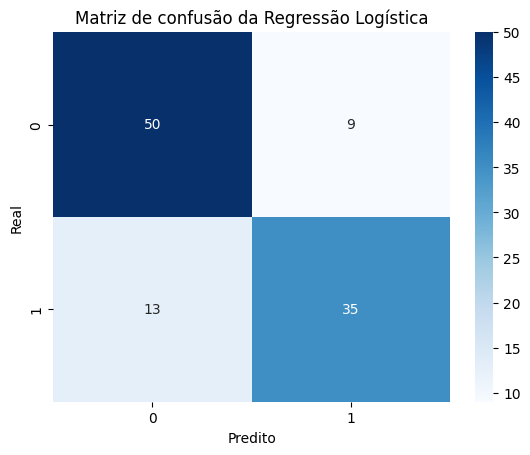

In [151]:
import statsmodels.api as sm

# Adicione uma constante aos dados de treinamento
X_train = sm.add_constant(X_train)

# Crie o modelo de regressão logística usando StatsModels
logit_model = sm.Logit(y_train, X_train)

# Ajuste o modelo aos dados de treinamento
logit_results = logit_model.fit(maxiter=1000, disp=False, verbose=0, tol=1e-4)

# Imprima os resultados do modelo
print(logit_results.summary())

# Adicione uma constante aos dados de teste
X_test = sm.add_constant(X_test)

# Faça previsões usando o modelo de regressão logística
logit_predictions = logit_results.predict(X_test)

# Converta as previsões em 0 ou 1
logit_predictions = np.where(logit_predictions > 0.5, 1, 0)

# Calcule a precisão do modelo
logit_accuracy = accuracy_score(y_test, logit_predictions)

# Imprima a precisão do modelo
print(f'Acurácia do modelo de regressão logística: {logit_accuracy}')

# Show the confusion matrix
confusion_matrix = pd.crosstab(y_test, logit_predictions, rownames=['Real'], colnames=['Predito'])
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g')

# Add title
plt.title('Matriz de confusão da Regressão Logística')

Text(0.5, 1.0, 'Comparativo de acertos')

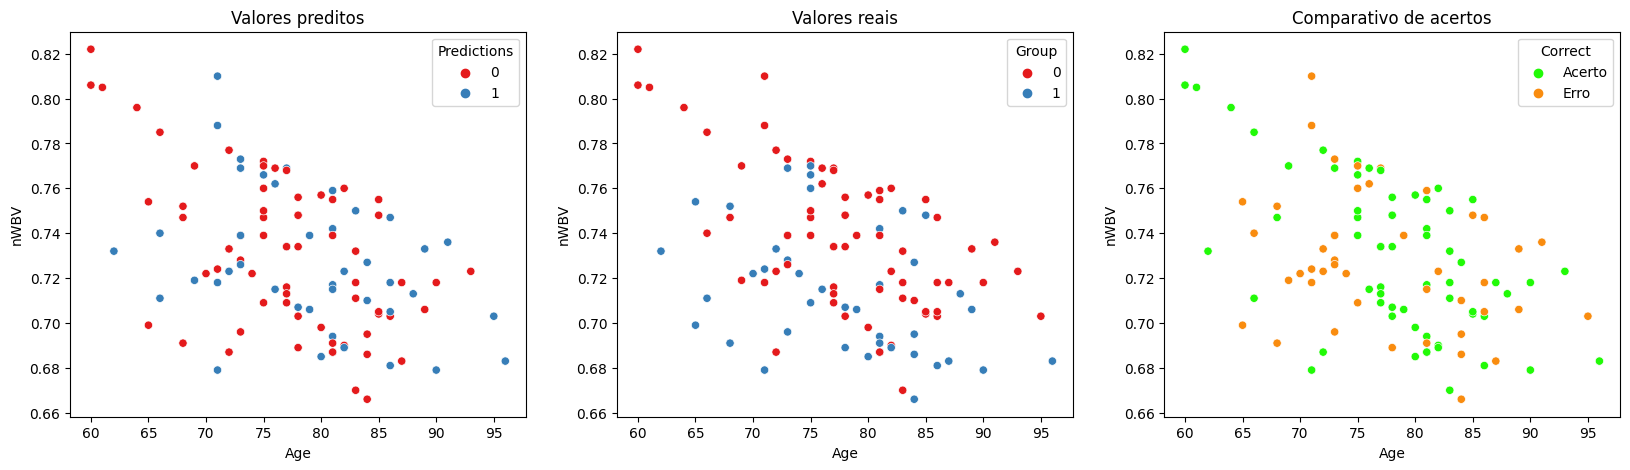

In [201]:
# Concatenando os dados de X_test_copy e y_test_copy
X_test_copy_1 = X_test_copy.copy()
X_test_copy_1['Group'] = y_test_copy

# Concatenando os dados de X_test_copy_1 e best_model['Regressão Logística'][8]
X_test_copy_1['Predictions'] = best_model['Regressão Logística'][8]

# Criando uma coluna para armazenar se o valor foi predito corretamente ou não
X_test_copy_1['Correct'] = X_test_copy_1['Group'] == X_test_copy_1['Predictions']

# Transformando os valores de "Correct" para Acerto e Erro
X_test_copy_1['Correct'] = X_test_copy_1['Correct'].map({True: 'Acerto', False: 'Erro'})

# Plotando dois gráficos de dispersão lado a lado
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Gráfico de dispersão para o valor predito
sns.scatterplot(x='Age', y='nWBV', data=X_test_copy_1, hue='Predictions', ax=ax1, palette='Set1')
ax1.set_title('Valores preditos')

# Gráfico de dispersão para o valor real
sns.scatterplot(x='Age', y='nWBV', data=X_test_copy_1, hue='Group', ax=ax2, palette='Set1')
ax2.set_title('Valores reais')

# Gráfico de dispersão para o valor predito
sns.scatterplot(x='Age', y='nWBV', data=X_test_copy_1, hue='Correct', ax=ax3, palette=['#21FA07', '#F98C0F'])
ax3.set_title('Comparativo de acertos')



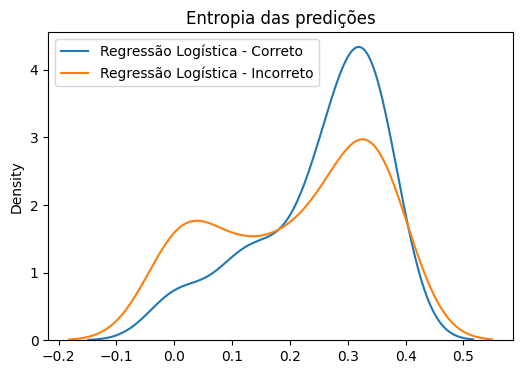

In [152]:
# Função de entropia
def entropy(probs):
    return torch.special.entr(probs)

# Obtendo as probabilidades corretas e incorretas
correct_logistic = (best_model['Regressão Logística'][8] == y_test)
probs_correct_logistic = best_model['Regressão Logística'][0].predict_proba(X_test)[correct_logistic][:, 1]
probs_incorrect_logistic = best_model['Regressão Logística'][0].predict_proba(X_test)[~correct_logistic][:, 1]

# Passar probs para tensor
probs_correct_logistic = torch.tensor(probs_correct_logistic)
probs_incorrect_logistic = torch.tensor(probs_incorrect_logistic)

# Plotando os gráficos
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
fig.subplots_adjust(wspace=0.3)

sns.kdeplot(data = entropy(probs_correct_logistic), label='Regressão Logística - Correto')
sns.kdeplot(data = entropy(probs_incorrect_logistic), label='Regressão Logística - Incorreto')
plt.title('Entropia das predições')

# Put a legend to the right side
plt.legend(loc='upper left')

plt.show()

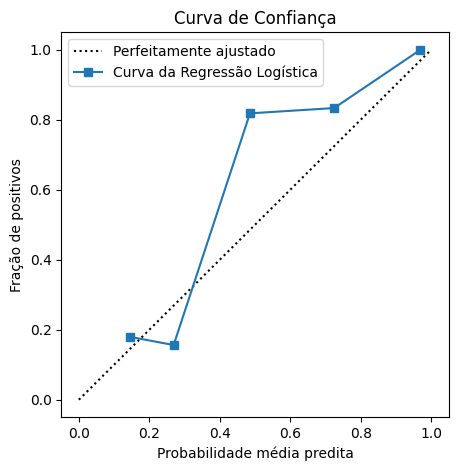

In [83]:
# Show calibration curve for the best model
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
calibration_curve = CalibrationDisplay.from_estimator(best_model['Regressão Logística'][0], X_test, y_test, ax=ax)
# calibration_curve.plot()

# Mudar legendas para português
plt.title('Curva de Confiança')
plt.xlabel('Probabilidade média predita')
plt.ylabel('Fração de positivos')
plt.legend(['Perfeitamente ajustado', 'Curva da Regressão Logística'])


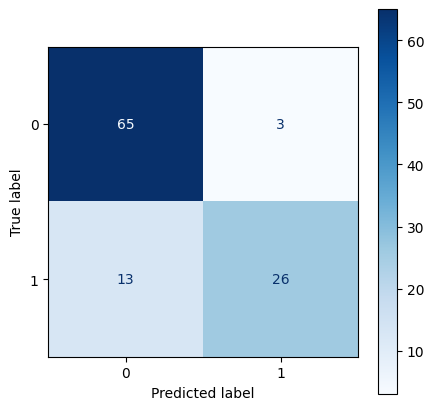

In [60]:
# Plot the confusion matrix for the best model
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
confusion_matrix = ConfusionMatrixDisplay.from_estimator(best_model['Regressão Logística'][0], X_test, y_test, ax=ax, cmap='Blues')